This is a script to create and register a naive non-ML baseline forecasting model.

**The model**: For a given input (with a timestamp index feature), it predicts the average electricity demand value for that month and hour of day.

This model is then registered to the MLFlow model registry.

# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import mlflow
import getpass

In [2]:
import os
print(os.getcwd())

/app/notebooks


In [3]:
# Auto reload core modules so I don't need to restart kernel when I change
# the code in those modules
%load_ext autoreload
%autoreload 2

In [44]:
#sys.path.append('../')
from core.data import (
    request_EIA_data, get_dvc_remote_repo_url, get_dvc_dataset_as_df,
)
from core.consts import EIA_TEST_SET_HOURS
from flows.train_model_flow import clean_data, features, mlflow_emit_tags_and_params
from flows.compare_models_flow import fetch_eval_dataset
from core.types import DVCDatasetInfo, MLFlowModelSpecifier
from core.utils import mlflow_endpoint_uri

# Get training data

In [5]:
git_PAT = getpass.getpass(prompt='Enter DVC git repo PAT')

Enter DVC git repo PAT ········


In [6]:
git_repo_url = get_dvc_remote_repo_url(git_PAT)
path = 'data/eia_d_df_2019-01-01_00_2024-08-17_00.parquet'
rev = '511314f2d0552f4b5396ef118bc45434d0939a2c'
dvc_dataset_info = DVCDatasetInfo(repo=git_repo_url, path=path, rev=rev)
df = get_dvc_dataset_as_df(dvc_dataset_info)

/usr/local/lib/python3.10/site-packages/dulwich/repo.py:888: DeprecationWarning: use get_user_identity() rather than Repo._get_user_identity
  warnings.warn(


19:40:57.685 | INFO    | great_expectations.data_context.types.base - Created temporary directory '/tmp/tmpxg6awrqb' for ephemeral docs site

Calculating Metrics:   0%|          | 0/15 [00:00<?, ?it/s]

GX Validation success: suite:etl


In [7]:
df

,utc_ts,D
utc_ts,,
2019-01-01 00:00:00+00:00,2019-01-01 00:00:00+00:00,94016.0
2019-01-01 01:00:00+00:00,2019-01-01 01:00:00+00:00,90385.0
2019-01-01 02:00:00+00:00,2019-01-01 02:00:00+00:00,86724.0
2019-01-01 03:00:00+00:00,2019-01-01 03:00:00+00:00,82978.0
2019-01-01 04:00:00+00:00,2019-01-01 04:00:00+00:00,79536.0
...,...,...
2024-08-16 20:00:00+00:00,2024-08-16 20:00:00+00:00,126636.0
2024-08-16 21:00:00+00:00,2024-08-16 21:00:00+00:00,128643.0
2024-08-16 22:00:00+00:00,2024-08-16 22:00:00+00:00,128935.0


In [9]:
df = clean_data(df)
df = features(df)

19:42:23.860 | INFO    | Task run 'clean_data' - Created task run 'clean_data' for task 'clean_data'

Input data skew: 157.80719172884187
Output data skew: 0.8479119351952286
Null demand values: 117


19:42:24.524 | INFO    | Task run 'clean_data' - Finished in state Completed()

19:42:24.576 | INFO    | Task run 'features' - Created task run 'features' for task 'features'

                                             utc_ts         D  hour  month  \
utc_ts                                                                       
2019-01-01 00:00:00+00:00 2019-01-01 00:00:00+00:00   94016.0     0      1   
2019-01-01 01:00:00+00:00 2019-01-01 01:00:00+00:00   90385.0     1      1   
2019-01-01 02:00:00+00:00 2019-01-01 02:00:00+00:00   86724.0     2      1   
2019-01-01 03:00:00+00:00 2019-01-01 03:00:00+00:00   82978.0     3      1   
2019-01-01 04:00:00+00:00 2019-01-01 04:00:00+00:00   79536.0     4      1   
...                                             ...       ...   ...    ...   
2024-08-16 20:00:00+00:00 2024-08-16 20:00:00+00:00  126636.0    20      8   
2024-08-16 21:00:00+00:00 2024-08-16 21:00:00+00:00  128643.0    21      8   
2024-08-16 22:00:00+00:00 2024-08-16 22:00:00+00:00  128935.0    22      8   
2024-08-16 23:00:00+00:00 2024-08-16 23:00:00+00:00  126208.0    23      8   
2024-08-17 00:00:00+00:00 2024-08-17 00:00:00+00:00  121761.0   

19:42:24.605 | INFO    | Task run 'features' - Finished in state Completed()

In [10]:
df

,utc_ts,D,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear
utc_ts,,,,,,,,,
2019-01-01 00:00:00+00:00,2019-01-01 00:00:00+00:00,94016.0,0,1,2019,1,1,1,1
2019-01-01 01:00:00+00:00,2019-01-01 01:00:00+00:00,90385.0,1,1,2019,1,1,1,1
2019-01-01 02:00:00+00:00,2019-01-01 02:00:00+00:00,86724.0,2,1,2019,1,1,1,1
2019-01-01 03:00:00+00:00,2019-01-01 03:00:00+00:00,82978.0,3,1,2019,1,1,1,1
2019-01-01 04:00:00+00:00,2019-01-01 04:00:00+00:00,79536.0,4,1,2019,1,1,1,1
...,...,...,...,...,...,...,...,...,...
2024-08-16 20:00:00+00:00,2024-08-16 20:00:00+00:00,126636.0,20,8,2024,3,4,16,229
2024-08-16 21:00:00+00:00,2024-08-16 21:00:00+00:00,128643.0,21,8,2024,3,4,16,229
2024-08-16 22:00:00+00:00,2024-08-16 22:00:00+00:00,128935.0,22,8,2024,3,4,16,229


Chop off the last `EIA_TEST_SET_HOURS` hours, so the training set leaves enough of a test set window for adhoc model evaluation.

In [11]:
df = df[:-EIA_TEST_SET_HOURS]

# Calculate average demand by hour

In [12]:
demand_by_hour_month = df.groupby(['hour','month'])['D'].agg(pd.Series.mean)
demand_by_hour_month

hour  month
0     1        105112.139785
      2        100940.605882
      3         89774.677596
      4         82412.405556
      5         88564.392473
                   ...      
23    8        121760.969464
      9        102162.340000
      10        86051.445161
      11        91628.154362
      12        99661.335484
Name: D, Length: 288, dtype: float64

In [13]:
type(demand_by_hour_month)
demand_by_hour_month[(23,8)]

121760.9694642188

# Define Baseline Model

Define my simple model (lookup table) function so that it implements the sci-kit learn [Predictor interface](https://scikit-learn.org/stable/developers/develop.html#different-objects).

In [14]:
class BaselineModel(mlflow.pyfunc.PythonModel):
    def __init__(self, demand_by_hour_month):
        self.dbhm = demand_by_hour_month
    
    def predict(self, context, model_input_df):
        # Assuming model_input contains a column 'hour' with the hour of the data point
        def demand_for_row(row):
            key_tuple = (row['hour'], row['month']) 
            return self.dbhm[key_tuple]
        return model_input_df.apply(demand_for_row, axis=1)

In [15]:
baseline_model = BaselineModel(demand_by_hour_month)

# Visualize model predictions

In [17]:
eval_df = fetch_eval_dataset()
eval_df

19:43:04.015 | INFO    | Task run 'fetch_eval_dataset' - Created task run 'fetch_eval_dataset' for task 'fetch_eval_dataset'

19:43:04.040 | INFO    | Task run 'get_eia_data_as_df' - Created task run 'get_eia_data_as_df' for task 'get_eia_data_as_df'

Fetching API page. offset:0. length:5000


19:43:05.744 | INFO    | Task run 'get_eia_data_as_df' - Finished in state Completed()

19:43:05.787 | INFO    | Task run 'transform' - Created task run 'transform' for task 'transform'

Transforming timeseries.
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 337 entries, 2024-09-29 00:00:00+00:00 to 2024-10-13 00:00:00+00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   utc_ts  337 non-null    datetime64[ns, UTC]
 1   D       337 non-null    int64              
dtypes: datetime64[ns, UTC](1), int64(1)
memory usage: 7.9 KB

Dataframe summary:
                                             utc_ts      D
utc_ts                                                    
2024-09-29 00:00:00+00:00 2024-09-29 00:00:00+00:00  92391
2024-09-29 01:00:00+00:00 2024-09-29 01:00:00+00:00  90330
2024-09-29 02:00:00+00:00 2024-09-29 02:00:00+00:00  87401
2024-09-29 03:00:00+00:00 2024-09-29 03:00:00+00:00  84542
2024-09-29 04:00:00+00:00 2024-09-29 04:00:00+00:00  81824
...                                             ...    ...
2024-10-12 20:00:00+00:00 2024-10-12 20:00:00+00:00  776

19:43:05.809 | INFO    | Task run 'transform' - Finished in state Completed()

19:43:05.833 | INFO    | Task run 'clean_data' - Created task run 'clean_data' for task 'clean_data'

Input data skew: -0.03955977638214278
Output data skew: -0.03955977638214278
Null demand values: 0


19:43:05.891 | INFO    | Task run 'clean_data' - Finished in state Completed()

19:43:05.911 | INFO    | Task run 'features' - Created task run 'features' for task 'features'

                                             utc_ts      D  hour  month  year  \
utc_ts                                                                          
2024-09-29 00:00:00+00:00 2024-09-29 00:00:00+00:00  92391     0      9  2024   
2024-09-29 01:00:00+00:00 2024-09-29 01:00:00+00:00  90330     1      9  2024   
2024-09-29 02:00:00+00:00 2024-09-29 02:00:00+00:00  87401     2      9  2024   
2024-09-29 03:00:00+00:00 2024-09-29 03:00:00+00:00  84542     3      9  2024   
2024-09-29 04:00:00+00:00 2024-09-29 04:00:00+00:00  81824     4      9  2024   
...                                             ...    ...   ...    ...   ...   
2024-10-12 20:00:00+00:00 2024-10-12 20:00:00+00:00  77644    20     10  2024   
2024-10-12 21:00:00+00:00 2024-10-12 21:00:00+00:00  79604    21     10  2024   
2024-10-12 22:00:00+00:00 2024-10-12 22:00:00+00:00  81135    22     10  2024   
2024-10-12 23:00:00+00:00 2024-10-12 23:00:00+00:00  81476    23     10  2024   
2024-10-13 00:00:00+00:00 20

19:43:05.920 | INFO    | Task run 'features' - Finished in state Completed()

Eval data df:
                                             utc_ts      D  hour  month  year  \
utc_ts                                                                          
2024-09-29 00:00:00+00:00 2024-09-29 00:00:00+00:00  92391     0      9  2024   
2024-09-29 01:00:00+00:00 2024-09-29 01:00:00+00:00  90330     1      9  2024   
2024-09-29 02:00:00+00:00 2024-09-29 02:00:00+00:00  87401     2      9  2024   
2024-09-29 03:00:00+00:00 2024-09-29 03:00:00+00:00  84542     3      9  2024   
2024-09-29 04:00:00+00:00 2024-09-29 04:00:00+00:00  81824     4      9  2024   
...                                             ...    ...   ...    ...   ...   
2024-10-12 20:00:00+00:00 2024-10-12 20:00:00+00:00  77644    20     10  2024   
2024-10-12 21:00:00+00:00 2024-10-12 21:00:00+00:00  79604    21     10  2024   
2024-10-12 22:00:00+00:00 2024-10-12 22:00:00+00:00  81135    22     10  2024   
2024-10-12 23:00:00+00:00 2024-10-12 23:00:00+00:00  81476    23     10  2024   
2024-10-13 00:

19:43:05.926 | INFO    | Task run 'fetch_eval_dataset' - Finished in state Completed()

,utc_ts,D,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear
utc_ts,,,,,,,,,
2024-09-29 00:00:00+00:00,2024-09-29 00:00:00+00:00,92391,0,9,2024,3,6,29,273
2024-09-29 01:00:00+00:00,2024-09-29 01:00:00+00:00,90330,1,9,2024,3,6,29,273
2024-09-29 02:00:00+00:00,2024-09-29 02:00:00+00:00,87401,2,9,2024,3,6,29,273
2024-09-29 03:00:00+00:00,2024-09-29 03:00:00+00:00,84542,3,9,2024,3,6,29,273
2024-09-29 04:00:00+00:00,2024-09-29 04:00:00+00:00,81824,4,9,2024,3,6,29,273
...,...,...,...,...,...,...,...,...,...
2024-10-12 20:00:00+00:00,2024-10-12 20:00:00+00:00,77644,20,10,2024,4,5,12,286
2024-10-12 21:00:00+00:00,2024-10-12 21:00:00+00:00,79604,21,10,2024,4,5,12,286
2024-10-12 22:00:00+00:00,2024-10-12 22:00:00+00:00,81135,22,10,2024,4,5,12,286


In [18]:
pred = baseline_model.predict(None, eval_df)

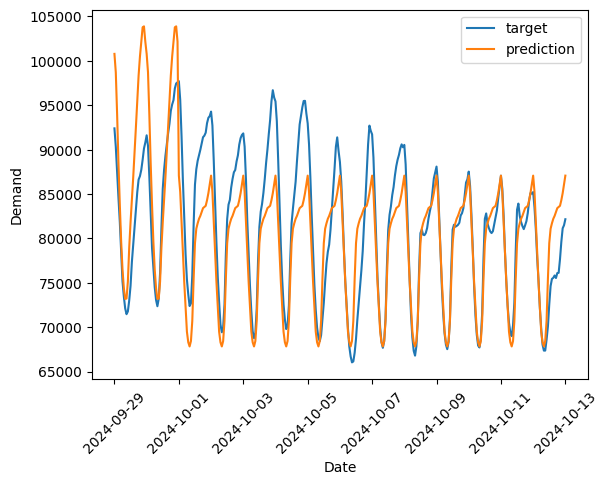

In [19]:
plt.plot(eval_df.index, eval_df.D, label='target')
plt.plot(eval_df.index, pred, label='prediction')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Demand')
plt.legend()
plt.show()

# Log the model to mlflow

In [46]:
mlflow.set_tracking_uri(uri=mlflow_endpoint_uri())
mlflow.set_experiment('xgb.df.register_baseline')
with mlflow.start_run():
    mlflow_emit_tags_and_params(df, dvc_dataset_info)
    mlflow.pyfunc.log_model(artifact_path="baseline_model", python_model=baseline_model)

2024/10/15 20:10:21 INFO mlflow.tracking.fluent: Experiment with name 'xgb.df.register_baseline' does not exist. Creating a new experiment.


20:10:21.299 | INFO    | Task run 'mlflow_emit_tags_and_params' - Created task run 'mlflow_emit_tags_and_params' for task 'mlflow_emit_tags_and_params'

20:10:21.719 | INFO    | Task run 'mlflow_emit_tags_and_params' - Finished in state Completed()

/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:16: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/importlib/__init__.py:126: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools 

# Visualize and Compare performance metrics over time

In [19]:
mlflow.set_tracking_uri(uri=mlflow_endpoint_uri())
runs = mlflow.search_runs(experiment_names=['xgb.df.compare_models'])
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.root_mean_squared_error,metrics.mean_on_target,metrics.example_count,metrics.mean_squared_error,...,metrics.mean_absolute_error,metrics.r2_score,params.model_version,params.model_name,tags.mlflow.user,tags.prefect_flow_run,tags.mlflow.datasets,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.runName
0,e45c5dbe3abd409bb548c08e6154867c,2,FINISHED,mlflow-artifacts:/2/e45c5dbe3abd409bb548c08e61...,2024-08-23 15:12:44.485000+00:00,2024-08-23 15:12:44.689000+00:00,15381.823312,100508.52819,337.0,2.366005e+08,...,13481.134412,-0.291989,1,xgboost-df,root,terrestrial-tarsier,"[{""name"":""b235be20d7476df3d9d55964e4cc12df"",""h...",/usr/local/lib/python3.10/site-packages/prefec...,LOCAL,xgboost-df-v1_eval


In [20]:
# Cast some types
runs['start_time'] = pd.to_datetime(runs['start_time'], utc=True)
runs['params.model_version'] = pd.to_numeric(runs['params.model_version'])
runs['metrics.root_mean_squared_error'] = pd.to_numeric(runs['metrics.root_mean_squared_error'])

In [21]:
runs.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.root_mean_squared_error,metrics.mean_on_target,metrics.example_count,metrics.mean_squared_error,...,metrics.mean_absolute_error,metrics.r2_score,params.model_version,params.model_name,tags.mlflow.user,tags.prefect_flow_run,tags.mlflow.datasets,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.runName
0,e45c5dbe3abd409bb548c08e6154867c,2,FINISHED,mlflow-artifacts:/2/e45c5dbe3abd409bb548c08e61...,2024-08-23 15:12:44.485000+00:00,2024-08-23 15:12:44.689000+00:00,15381.823312,100508.52819,337.0,2.366005e+08,...,13481.134412,-0.291989,1,xgboost-df,root,terrestrial-tarsier,"[{""name"":""b235be20d7476df3d9d55964e4cc12df"",""h...",/usr/local/lib/python3.10/site-packages/prefec...,LOCAL,xgboost-df-v1_eval


In [22]:
runs.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.root_mean_squared_error', 'metrics.mean_on_target',
       'metrics.example_count', 'metrics.mean_squared_error',
       'metrics.mean_absolute_percentage_error', 'metrics.sum_on_target',
       'metrics.max_error', 'metrics.mean_absolute_error', 'metrics.r2_score',
       'params.model_version', 'params.model_name', 'tags.mlflow.user',
       'tags.prefect_flow_run', 'tags.mlflow.datasets',
       'tags.mlflow.source.name', 'tags.mlflow.source.type',
       'tags.mlflow.runName'],
      dtype='object')

In [23]:
def filter_runs(runs_df, model_name, model_version):
    mn_mask = runs_df['params.model_name'] == model_name
    mv_mask = runs_df['params.model_version'] == model_version
    return runs_df[mn_mask & mv_mask]

models = [MLFlowModelSpecifier(name='baseline', version=4), MLFlowModelSpecifier(name='xgboost-df', version=2)]

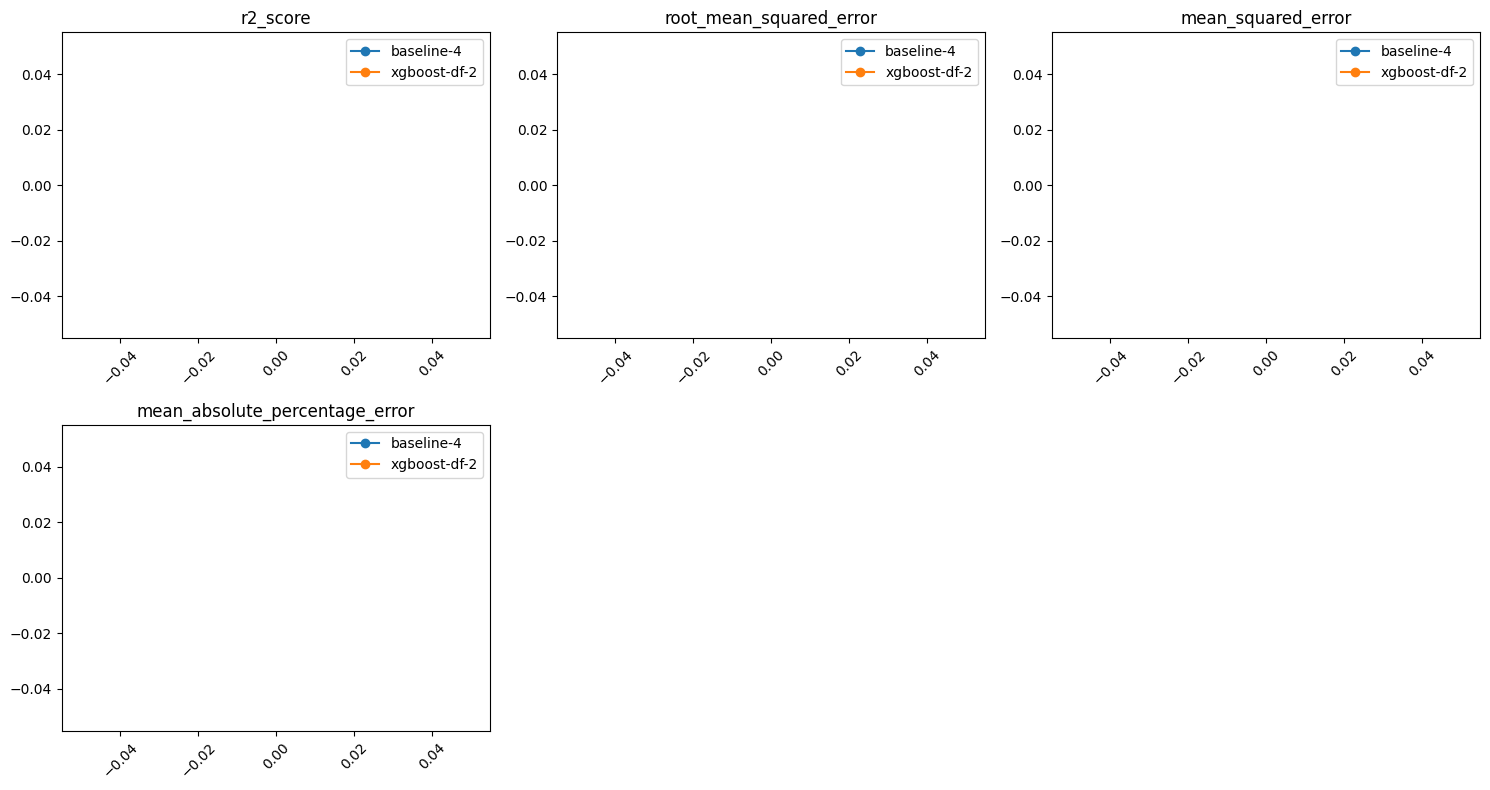

In [24]:
metrics = ['r2_score', 'root_mean_squared_error', 'mean_squared_error', 'mean_absolute_percentage_error']
num_cols = 3
num_rows = (len(metrics) // num_cols) + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axs = axs.flat
for m in models:
    model_runs_df = filter_runs(runs, m.name, m.version)
    for i, metric in enumerate(metrics):
        #print(f'model:{m.name}. metric:{metric}. data:{model_runs_df[f"metrics.{metric}"]}')
        axs[i].set_title(metric)
        axs[i].plot(model_runs_df.start_time, model_runs_df[f'metrics.{metric}'], 
                 marker='o', label=f'{m.name}-{m.version}')
        axs[i].legend()
        axs[i].tick_params(axis='x', rotation=45)
        
# Remove axes for any extra subplots beyond the number of metrics
for i in range(len(metrics), len(axs)):
    fig.delaxes(axs[i])
    
plt.tight_layout()
plt.show()

In [25]:
from flows.compare_models_flow import generate_performance_plot

await generate_performance_plot(['xgboost-df', 'baseline'])

15:58:42.958 | INFO    | prefect.engine - Created task run 'generate_performance_plot-7376230c' for task 'generate_performance_plot'

Summary of runs for experiment xgb.df.compare_models:
                             run_id experiment_id    status  \
0  e45c5dbe3abd409bb548c08e6154867c             2  FINISHED   

                                        artifact_uri  \
0  mlflow-artifacts:/2/e45c5dbe3abd409bb548c08e61...   

                        start_time                         end_time  \
0 2024-08-23 15:12:44.485000+00:00 2024-08-23 15:12:44.689000+00:00   

   metrics.root_mean_squared_error  metrics.mean_on_target  \
0                     15381.823312            100508.52819   

   metrics.example_count  metrics.mean_squared_error  ...  \
0                  337.0                2.366005e+08  ...   

   metrics.mean_absolute_error  metrics.r2_score  params.model_version  \
0                 13481.134412         -0.291989                     1   

   params.model_name  tags.mlflow.user tags.prefect_flow_run  \
0         xgboost-df              root   terrestrial-tarsier   

                                tags.

2024/08/23 15:58:43 INFO mlflow.tracking.fluent: Experiment with name 'xgb.df.compare_models_plot' does not exist. Creating a new experiment.
2024/08/23 15:58:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run bright-doe-632 at: http://mlflow:5001/#/experiments/3/runs/442e15bcd0134446842c94c3a8a50abd.
2024/08/23 15:58:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow:5001/#/experiments/3.


15:58:43.707 | INFO    | Task run 'generate_performance_plot-7376230c' - Finished in state Completed()

In [26]:
from mlflow import MlflowClient
client = MlflowClient()
experiment_name = "xgb.df.compare_models"
experiment = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids=[experiment.experiment_id])

In [27]:
runs[0].info

<RunInfo: artifact_uri='mlflow-artifacts:/2/e45c5dbe3abd409bb548c08e6154867c/artifacts', end_time=1724425964689, experiment_id='2', lifecycle_stage='active', run_id='e45c5dbe3abd409bb548c08e6154867c', run_name='xgboost-df-v1_eval', run_uuid='e45c5dbe3abd409bb548c08e6154867c', start_time=1724425964485, status='FINISHED', user_id='root'>